<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/05_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN
## 目的
Cycle GANのネットワークを構築して動作を理解する．

# データセット
りんごとオレンジが含まれるデータセットのzipファイルをダウンロードして，解凍します．
もし違うデータを使いたい場合は，以下のURLから選択してURL先のデータをwgetで取得してください．<br>
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [ ]:
!wget -q https://www.dropbox.com/s/on1jla0d3ghjmff/apple2orange.zip?dl=0 -O apple2orange.zip
!unzip -q -o apple2orange.zip

# 各種モジュールのインポート

In [ ]:
import os
import random
import itertools
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ネットワークの構築
CycleGANは，「画像を入力→異なるスタイルへ変換→変換したものを元のスタイルへ戻す」という処理によって，対になる画像がない場合であってもスタイルを変換できる代物です．<br>
以下に示す図は，CycleGANによる変換及び再構成を表しています．


<img src="https://www.dropbox.com/s/7339ohcadohs6o7/Cyclegan.png?dl=1" width=40%>



CycleGANが提案される前は，pix2pixと呼ばれるペア画像を必要とするスタイル変換が主流でした．
ペア画像とは，例えばRGB画像とその画像に対するセグメンテーション画像のことを指します．<br>

CycleGANのGeneratorはResidual networkをベースに設計します．
Residual network (ResNet)は，残差機構を用いることで多層になった場合でも特徴を残すことが可能なネットワークです．
ResBlockは，カーネルサイズ3×3，ストライド1，パディング1の2層の畳み込み層で構築します．
以下にResBlockの図を示します．

<img src="https://www.dropbox.com/s/pow1wsxhc37gmts/ResBlock.png?dl=1" width=50%>

ここで$f(x)$は，前層が出力した特徴マップを表しています．
また$g(x)$は，残差を加算した特徴マップです．


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, features):
        super(ResBlock, self).__init__()
        block_list = []
        self.block = self.make_block(block_list, features)
        
    def make_block(self, modules_list, features):
        modules_list.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
        modules_list.append(self.select_normalization(norm='instance', features=features))
        modules_list.append(nn.ReLU(inplace=True))
        modules_list.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
        modules_list.append(self.select_normalization(norm='instance', features=features))
        modules = nn.Sequential(*modules_list)
        return modules
        
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm

    def forward(self, x):
        out = x + self.block(x)
        return out

CycleGANのGeneratorは，入力に潜在変数ではなく変換元となる画像を入力して，画像を出力します．そのため，GeneratorはEncoder-Decoder構造をしています．Encoderは，入力画像を表現するために有益な情報を残した特徴抽出をします．一方で，DecoderはEncoderがエンコードした特徴を用いて画像の変換をします．このときにEncoderとDecoderの間には，任意の数積み上げたResBlockを使用することで，さらに特徴を凝縮します．
ここで，ResBlockは，残差を用いてネットワークを構築するResidual Networksで使用されているものです．

<img src="https://www.dropbox.com/s/yha9im0bbb6p0t1/CycleGAN_G.png?dl=1" width=50%>

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_down, n_up, n_res, in_features):
        super(Generator, self).__init__()
        
        out_features = 16
        first_conv = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, out_features, kernel_size=7, stride=1, padding=0, bias=False),
            self.select_normalization(norm='instance', features=out_features),
            nn.ReLU(inplace=True)]
        
        down_block = []
        for _ in range(n_down):
            in_features = out_features
            out_features = in_features * 2
            down_block += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=False),
                self.select_normalization(norm='instance', features=out_features),
                nn.ReLU(inplace=True)]
            
        res_block = []
        res_features = out_features
        for _ in range(n_res):
            res_block.append(ResBlock(res_features))
            
        up_block = []
        in_features = res_features
        out_features = in_features // 2
        for _ in range(n_up):
            up_block += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                self.select_normalization(norm='instance', features=out_features),
                nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2
            
        #up_block += [
        #    nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
        #    self.select_normalization(norm='instance', features=out_features),
        #    nn.Tanh()]
        
        last_conv = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, 3, kernel_size=7, stride=1, padding=0, bias=True),
            nn.Tanh()]
        
        self.first_conv = nn.Sequential(*first_conv)
        self.down_block = nn.Sequential(*down_block)
        self.res_block = nn.Sequential(*res_block)
        self.up_block = nn.Sequential(*up_block)
        self.last_conv = nn.Sequential(*last_conv)
    
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm
            
    def forward(self, x):
        h = self.first_conv(x)
        h = self.down_block(h)
        h = self.res_block(h)
        h = self.up_block(h)
        out = self.last_conv(h)   
        return out

Discriminatorは，実画像であるかGeneratorによって変換された画像であるかの分類をするため，通常のGANと同じ振る舞いです．
DC-GANは，画像1枚を入力して実画像であるか生成画像であるかを判定しています．
つまり，Dicriminatorは画像全体を見て判断していると言っても良いでしょう．<br>
ところが，CycleGANはPatchGANをベースにDiscriminatorを構築しているので，少し変わった方法で実画像か生成画像かの判定をしています．
PatchGANは，画像全体ではなく画像をいくつかのパッチに区切って入力することで，局所領域ごとに実画像なのか生成画像なのかを判定します．
これによって，画像全体で判定するよりも性能がよくなることが知られています．
以下に通常のDiscriminatorとCycleGANのDsicriminatorを示します．



<img src="https://www.dropbox.com/s/yrud8444g26g0yz/CycleGAN_D.png?dl=1" width=50%>

図にも示したように，厳密には任意の数のPatchに分割することは手間なので，Discriminator内部の畳み込み処理のカーネルサイズによって受容野の広さを制御して，出力値をスカラー値ではなく特徴マップとすることによってPatchに分割したときと同様の処理を実現しています．

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_layers=3):
        super(Discriminator, self).__init__()
        out_features = 32
        modules = [nn.Conv2d(3, out_features, kernel_size=4, stride=2, padding=1, bias=True),
                   nn.LeakyReLU(negative_slope=0.2, inplace=True)]

        for _ in range(n_layers):
            in_features = out_features
            out_features = in_features * 2
            modules += [nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1, bias=False),
                        self.select_normalization(norm='instance', features=out_features),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True)]
        
        modules += [nn.Conv2d(out_features, 1, kernel_size=4, stride=1, padding=1, bias=True)]
        self.layers = nn.Sequential(*modules)
    
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm
            
    def forward(self, x):
        out = self.layers(x)
        return out

# DataLoaderの定義
pytorchに含まれているデータ以外のデータセットを用いて学習するときや特殊なデータ構造を利用して学習をする時は，DataLoaderを自分で定義する必要があります．今回使用するデータセットは，zipファイルを解凍すると，内部にtrainA，trainB，testA，testBという名前のディレクトリが含まれています．
また，それぞれのディレクトリの中に画像が入っています．

これらを考慮して以下に示すようにDataLoaderを定義します．

datapath：zipファイルを解凍したときにできるディレクトリのパス


In [ ]:
class CycleGAN_Dataset(torch.utils.data.Dataset):
    def __init__(self, datapath, transforms=None):
        self.transforms = transforms
        self.A_path = os.path.join(datapath, 'trainA')
        self.B_path = os.path.join(datapath, 'trainB')
        dataA_list = os.listdir(self.A_path)
        dataB_list = os.listdir(self.B_path)
        random.shuffle(dataA_list)
        random.shuffle(dataB_list)
        self.datalength = min(len(dataA_list), len(dataB_list))
        self.dataA = dataA_list[:self.datalength]
        self.dataB = dataB_list[:self.datalength]
        
    def __len__(self):
        return self.datalength
    
    def __getitem__(self, i):
        imgA = Image.open(os.path.join(self.A_path, self.dataA[i]))
        imgB = Image.open(os.path.join(self.B_path, self.dataB[i]))
        
        if self.transforms:
            imgA = self.transforms(imgA)
            imgB = self.transforms(imgB)
        
        return imgA, imgB

# Image History Buffer
CycleGANでは，任意のサイズのBufferを定義します．
これにより，過去にDiscriminatorをうまく騙せた画像に依存して変換のバリエーションが少なくなる問題を回避することができます．

Image Bufferは，Generatorが変換した画像を溜め込みますが，任意のiteration数で中身の画像を最新の画像にアップデートします．このときに，全ての画像を破棄して新しいものへアップデートするのではなく，一部のみをアップデートします．つまり，異なるiteration数で変換した画像が混在したBufferとなっています．

In [ ]:
class Image_History_Buffer:
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []
        
    def query(self, images):
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [ ]:
def get_lambda_rule(start_epoch, decay_epoch, epochs):
    def lambda_rule(epoch):
        return 1.0 - max(0, epoch + start_epoch - decay_epoch) / float(epochs - decay_epoch)
    return lambda_rule

# ネットワークの作成，学習に必要なパラメータの定義
CycleGANは，ドメインAからBに変換するGeneratorとその逆の処理をするGeneratorの2つ作成する必要があります．また，Discriminatorも同様で，ドメインAのためのDiscriminator，ドメインBのためのDicriminatorも作成します．

In [ ]:
lr = 2e-4
img_size = 256
max_size = 12800
betas = (0.5, 0.999)
batchsize = 1
imgsize = 256
n_epochs = 10
pool_size = 100
datapath = 'apple2orange'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize(img_size, Image.BICUBIC),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
train_data = CycleGAN_Dataset(datapath=datapath, transforms=transform)
training_dataset = DataLoader(train_data, batch_size=batchsize, shuffle=True , drop_last=True)
G_A2B = Generator(n_down=5, n_up=5, n_res=9, in_features=3).to(device)
G_B2A = Generator(n_down=5, n_up=5, n_res=9, in_features=3).to(device)
D_A = Discriminator(n_layers=3).to(device)
D_B = Discriminator(n_layers=3).to(device)
g_opt = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=betas)
d_A_opt = optim.Adam(D_A.parameters(), lr=lr, betas=betas)
d_B_opt = optim.Adam(D_B.parameters(), lr=lr, betas=betas)
l1_norm = nn.L1Loss()
criterion_idn = nn.L1Loss()
LambdaLR = get_lambda_rule(start_epoch=0, decay_epoch=100, epochs=n_epochs)
g_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(g_opt, lr_lambda=LambdaLR)
d_a_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_A_opt, lr_lambda=LambdaLR)
d_b_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_B_opt, lr_lambda=LambdaLR)
buffer_for_fakeA = Image_History_Buffer(pool_size=pool_size)
buffer_for_fakeB = Image_History_Buffer(pool_size=pool_size)

# CycleGANの学習
これまでに定義したネットワークを用いて学習します．

CycleGANの誤差関数は，オリジナルのGANとは異なるものが使用されています．
* Real/Fakeの誤差関数：GANを学習するために必要な誤差関数です．LS-GANで提案されているカイ2乗誤差を誤差関数とする方法を利用しています．
$$\mathcal{L}_{adv}^{A} = \mathbb{E}\left[\left(D_{A}(x_{A}) - 1\right)^{2}\right] + \mathbb{E}\left[D_{A}\left(G_{B\rightarrow A}(x_{B})\right)^{2}\right]$$
$$\mathcal{L}_{adv}^{B} = \mathbb{E}\left[\left(D_{B}(x_{B}) - 1\right)^{2}\right] + \mathbb{E}\left[D_{B}\left(G_{A\rightarrow B}(x_{A})\right)^{2}\right]$$
* Cycle consistency loss：オリジナルの画像と再構成した画像の一貫性を保つために必要な誤差関数です．
$$
\mathcal{L}_{cycle}^{A} = \|x_{A} - G_{B\rightarrow A}\left(G_{A\rightarrow B}\left(x_{A}\right)\right)\|_{1}
$$
$$
\mathcal{L}_{cycle}^{B} = \|x_{B} - G_{A\rightarrow B}\left(G_{B\rightarrow A}\left(x_{B}\right)\right)\|_{1}
$$
* Identity loss：別のスタイルへ変換したときにオリジナル画像を大幅に変更してしまうことを抑制するために必要な誤差です．実際，この誤差を抜いても学習は可能で，スタイルの変換もすることはできます．この誤差関数が最大の効果を発揮する場面は，ある風景画を絵画風に変換するときです．
$$
\mathcal{L}_{identity}^{A} = \|x_{A} - G_{A\rightarrow B}\left(x_{A}\right)\|_{1}
$$
$$
\mathcal{L}_{identity}^{B} = \|x_{B} - G_{B\rightarrow A}\left(x_{B}\right)\|_{1}
$$

In [ ]:
for epoch in range(1, n_epochs+1):
    for idx, (imgA, imgB) in enumerate(training_dataset):
        lambda_val = 10
        lambda_id_val = 0.5 * lambda_val
        imgA, imgB = imgA.cuda(), imgB.cuda()
        
        # Update the discriminator (D_A, D_B)
        D_A.zero_grad()
        D_B.zero_grad()
        disA_out_real = D_A(imgA)
        disB_out_real = D_B(imgB)

        imgB_fake = G_A2B(imgA)
        imgB_fake = buffer_for_fakeB.query(imgB_fake)
        disB_out_fake = D_B(imgB_fake.detach())
        
        imgA_fake = G_B2A(imgB)
        imgA_fake = buffer_for_fakeA.query(imgA_fake)
        disA_out_fake = D_A(imgA_fake.detach())
        disA_loss = 0.5 * (((disA_out_real - 1) ** 2).mean() + (disA_out_fake ** 2).mean())
        disB_loss = 0.5 * (((disB_out_fake - 1) ** 2).mean() + (disB_out_fake ** 2).mean())
        disA_loss.backward()
        disB_loss.backward()
        d_A_opt.step()
        d_B_opt.step()
        
        # Update the generator (G)
        G_B2A.zero_grad()
        G_A2B.zero_grad()
        disB_out_fake = D_B(imgB_fake)
        disA_out_fake = D_A(imgA_fake)
        gen_adv_loss = 0.5 * (((disB_out_fake - 1) ** 2).mean() + ((disA_out_fake - 1) ** 2).mean())
        
        imgA_rec = G_B2A(imgB_fake)
        imgB_rec = G_A2B(imgA_fake)
        cycle_consistency_loss = 0.5 * (l1_norm(imgA_rec, imgA) + l1_norm(imgB_rec, imgB))
        identity_loss = 0.5 * (criterion_idn(G_B2A(imgB_fake), imgA) + criterion_idn(G_A2B(imgA_fake), imgB))
        gen_loss = gen_adv_loss + lambda_val * cycle_consistency_loss + lambda_id_val * identity_loss
        gen_loss.backward()
        g_opt.step()
        
        if idx % 100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss (A): {:.6f} | D loss (B): {:.6f} | G loss: {:.6f} | Consistency: {:.6f} | Identity: {:.6f} |'\
                  .format(epoch, idx * len(imgA), len(training_dataset.dataset),
                  100. * idx / len(training_dataset), disA_loss.item(), disB_loss.item(), gen_loss.item(), cycle_consistency_loss.item(), identity_loss.item()))

Training epoch: 1 [0/995 (0%)] | D loss (A): 0.437663 | D loss (B): 0.674687 | G loss: 11.756495 | Consistency: 0.757436 | Identity: 0.757436 |
Training epoch: 1 [100/995 (10%)] | D loss (A): 0.062702 | D loss (B): 0.265966 | G loss: 7.253510 | Consistency: 0.440926 | Identity: 0.440926 |
Training epoch: 1 [200/995 (20%)] | D loss (A): 0.030655 | D loss (B): 0.267046 | G loss: 6.726613 | Consistency: 0.406833 | Identity: 0.406833 |
Training epoch: 1 [300/995 (30%)] | D loss (A): 0.008233 | D loss (B): 0.252266 | G loss: 8.831206 | Consistency: 0.543829 | Identity: 0.543829 |
Training epoch: 1 [400/995 (40%)] | D loss (A): 0.004676 | D loss (B): 0.318139 | G loss: 8.079090 | Consistency: 0.497600 | Identity: 0.497600 |
Training epoch: 1 [500/995 (50%)] | D loss (A): 0.008873 | D loss (B): 0.255873 | G loss: 7.964970 | Consistency: 0.483224 | Identity: 0.483224 |
Training epoch: 1 [600/995 (60%)] | D loss (A): 0.008779 | D loss (B): 0.253591 | G loss: 10.550163 | Consistency: 0.657932 | 

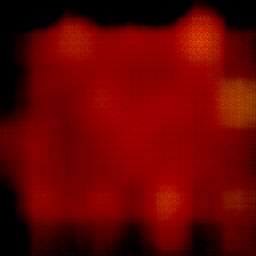

In [ ]:
testimg_path = 'apple2orange/testA'
img_list = os.listdir(testimg_path)
img_idx = np.random.randint(len(img_list))
test_imgA = Image.open(os.path.join(testimg_path, img_list[img_idx]))
to_tensor = transforms.ToTensor()
test_imgA_tensor = to_tensor(test_imgA).unsqueeze(0).cuda()
fake_test_B = G_A2B(test_imgA_tensor)
Image.fromarray((fake_test_B * 256.).clamp(min=0., max=255.).data.cpu().squeeze().numpy().transpose(1, 2, 0).astype(np.uint8))

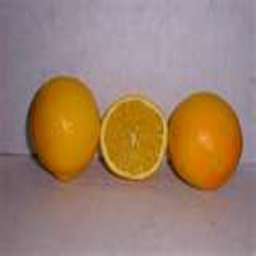

In [ ]:
test_imgA

# 課題


*   データセットを変更して学習してみましょう．
*   学習する際に使用しているCycle consistency lossやIdentity lossを使用しない場合，どのような結果が得られるか確認してみましょう．

